In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Define the alpha value for the post-plasma materials
alpha = 0.65

# Define the color for each material
cb_colors = {
    'γ-Al₂O₃': (0/255, 0/255, 0/255),
    '2% CuO@γ-Al₂O₃': (86/255, 180/255, 233/255),
    '10% CuO@γ-Al₂O₃': (0/255, 114/255, 178/255),
    '2% Fe₂O₃@γ-Al₂O₃': (230/255, 159/255, 0/255),
    '10% Fe₂O₃@γ-Al₂O₃': (213/255, 94/255, 0/255),

    'γ-Al₂O₃ pre-plasma': (
        (0 * alpha + 255 * (1 - alpha)) / 255,
        (0 * alpha + 255 * (1 - alpha)) / 255,
        (0 * alpha + 255 * (1 - alpha)) / 255
    ),
    '2% CuO@γ-Al₂O₃ pre-plasma': (
        (86 * alpha + 255 * (1 - alpha)) / 255,
        (180 * alpha + 255 * (1 - alpha)) / 255,
        (233 * alpha + 255 * (1 - alpha)) / 255
    ),
    '10% CuO@γ-Al₂O₃ pre-plasma': (
        (0 * alpha + 255 * (1 - alpha)) / 255,
        (114 * alpha + 255 * (1 - alpha)) / 255,
        (178 * alpha + 255 * (1 - alpha)) / 255
    ),
    '10% CuO@γ-Al₂O₃\npre-plasma': (
        (0 * alpha + 255 * (1 - alpha)) / 255,
        (114 * alpha + 255 * (1 - alpha)) / 255,
        (178 * alpha + 255 * (1 - alpha)) / 255
    ),
    '2% Fe₂O₃@γ-Al₂O₃ pre-plasma': (
        (230 * alpha + 255 * (1 - alpha)) / 255,
        (159 * alpha + 255 * (1 - alpha)) / 255,
        (0 * alpha + 255 * (1 - alpha)) / 255
    ),
    '10% Fe₂O₃@γ-Al₂O₃ pre-plasma': (
        (213 * alpha + 255 * (1 - alpha)) / 255,
        (94 * alpha + 255 * (1 - alpha)) / 255,
        (0 * alpha + 255 * (1 - alpha)) / 255
    ),
    'γ-Al₂O₃ post-plasma': (0/255, 0/255, 0/255),
    '2% CuO@γ-Al₂O₃ post-plasma': (86/255, 180/255, 233/255),
    '10% CuO@γ-Al₂O₃ post-plasma': (0/255, 114/255, 178/255),
    '10% CuO@γ-Al₂O₃\npost-plasma': (0/255, 114/255, 178/255),
    '2% Fe₂O₃@γ-Al₂O₃ post-plasma': (230/255, 159/255, 0/255),
    '10% Fe₂O₃@γ-Al₂O₃ post-plasma': (213/255, 94/255, 0/255)
}

# determine order of materials for plotting
material_order = [
    'γ-Al₂O₃',
    '2% CuO@γ-Al₂O₃',
    '2% Fe₂O₃@γ-Al₂O₃',
    '10% CuO@γ-Al₂O₃',
    '10% Fe₂O₃@γ-Al₂O₃',
    'γ-Al₂O₃ pre-plasma',
    '2% CuO@γ-Al₂O₃ pre-plasma',
    '2% Fe₂O₃@γ-Al₂O₃ pre-plasma',
    '10% CuO@γ-Al₂O₃ pre-plasma',
    '10% Fe₂O₃@γ-Al₂O₃ pre-plasma',
    'γ-Al₂O₃ post-plasma',
    '2% CuO@γ-Al₂O₃ post-plasma',
    '2% Fe₂O₃@γ-Al₂O₃ post-plasma',
    '10% CuO@γ-Al₂O₃ post-plasma',
    '10% Fe₂O₃@γ-Al₂O₃ post-plasma'
]

In [3]:
# Define the path to the Excel file
excel_file_path = (
    r'N:\FWET\FDCH\AdsCatal\General\personal_work_folders\plasmacatdesign'
    r'\materials\ugent\ugent-tga-dsc-ms.xlsx'
)

# Read all worksheets in the Excel file into a dictionary of DataFrames
data = pd.read_excel(excel_file_path, sheet_name=['tga_dsc', 'ms'])

# Assign each DataFrame to a separate variable
tga_dsc_data = data['tga_dsc']
ms_data = data['ms']

# Cast the 'date' column to a datetime object
tga_dsc_data['date'] = pd.to_datetime(tga_dsc_data['date'])

# Create a column for the material and plasma combination
tga_dsc_data['material_plasma'] = (
    tga_dsc_data['material']
    + ' '
    + tga_dsc_data['plasma']
)

In [4]:
# Group measurements by material, plasma, date and gas
grouped = tga_dsc_data.groupby(['material', 'plasma', 'date', 'gas'])

# Take a gaussian running mean of the grouped data
# for the column 'temp_sample_dC'
columns_to_transform = [
    'temp_sample_dC',
    'heat_flow_Wperg',
    'mass_percent',
    'temp_ref_dC'
]

new_column_names = [col + '_gaussian' for col in columns_to_transform]

window_size = 50

for col, new_col in zip(columns_to_transform, new_column_names):
    tga_dsc_data[new_col] = grouped[col].transform(
        lambda x: x.rolling(
            window=window_size,
            center=True,
            win_type='gaussian'
            ).mean(std=window_size/2)
        )

# Calculate the derivative of the mass_percent_gaussian column
# to the temp_sample_dC_gaussian column
tga_dsc_data['mass_percent_derivative'] = np.gradient(
    tga_dsc_data['mass_percent_gaussian'],
    tga_dsc_data['temp_sample_dC_gaussian']
)

In [5]:
# Select the most recent measurements to plot
tga_dsc_data['max_date'] = tga_dsc_data.groupby(
    ['material', 'plasma', 'gas']
    )['date'].transform('max')
tga_dsc_data = tga_dsc_data[tga_dsc_data['date'] == tga_dsc_data['max_date']]
tga_dsc_data = tga_dsc_data.drop(columns=['max_date'])

# Prepare the data by selecting the measurements
# where Ar and O2 is used as a gas
tga_dsc_data_Ar = tga_dsc_data[tga_dsc_data['gas'] == 'Ar'].copy()
tga_dsc_data_O2 = tga_dsc_data[tga_dsc_data['gas'] == 'O2'].copy()

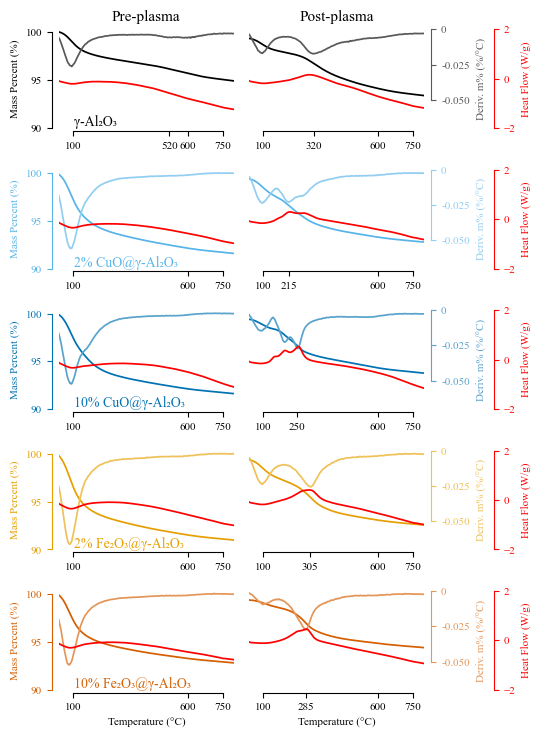

In [6]:
# Use Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# Set font size
plt.rcParams['font.size'] = 10

# Set the size of the figure in inches (1 inch = 25.4 mm)
fig, axes = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=(140/25.4, 190/25.4),
    
)

# Now, axes is a 5x2 array
ax1a = axes[0, 0]
ax1b = ax1a.twinx()
ax1c = ax1a.twinx()
ax2a = axes[0, 1]
ax2b = ax2a.twinx()
ax2c = ax2a.twinx()
ax3a = axes[1, 0]
ax3b = ax3a.twinx()
ax3c = ax3a.twinx()
ax4a = axes[1, 1]
ax4b = ax4a.twinx()
ax4c = ax4a.twinx()
ax5a = axes[2, 0]
ax5b = ax5a.twinx()
ax5c = ax5a.twinx()
ax6a = axes[2, 1]
ax6b = ax6a.twinx()
ax6c = ax6a.twinx()
ax7a = axes[3, 0]
ax7b = ax7a.twinx()
ax7c = ax7a.twinx()
ax8a = axes[3, 1]
ax8b = ax8a.twinx()
ax8c = ax8a.twinx()
ax9a = axes[4, 0]
ax9b = ax9a.twinx()
ax9c = ax9a.twinx()
ax10a = axes[4, 1]
ax10b = ax10a.twinx()
ax10c = ax10a.twinx()

# Set the title for the left column of plots
ax1a.set_title('Pre-plasma', fontsize=11)

# Set the title for the right column of plots
ax2a.set_title('Post-plasma', fontsize=11)


# Despine the ax1 plot for a cleaner look
sns.despine(
    ax=ax1a,
    left=False, top=True, right=True, bottom=False
)
sns.despine(
    ax=ax1b,
    left=True, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax1c,
    left=True, top=True, right=True, bottom=True
)

# Create a line plot on ax1a for the pre-plasma gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color=(0/255, 0/255, 0/255),
    linewidth=1.25,
    legend=False,
    ax=ax1a
)

# ax1a x-axis settings
ax1a.set_xlim([40, 800])
ax1a.spines['bottom'].set_bounds(100, 750)
ax1a.spines['bottom'].set_position(('outward', 2))
ax1a.set_xlabel(None)
ax1a.set_xticks(ticks=[100, 520, 600, 750])
ax1a.tick_params(axis='x', labelsize=8)

# ax1a y-axis settings
ax1a.spines['left'].set_position(('outward', 5))
ax1a.spines['left'].set_bounds(90, 100)
ax1a.set_ylabel(ylabel='Mass Percent (%)', fontsize=8)
ax1a.set_yticks(ticks=[90, 95, 100])
ax1a.tick_params(axis='y', labelsize=8)

# Create a line plot on ax1b
# for the pre-plasma gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color=((0*alpha+255*(1-alpha))/255,
           (0*alpha+255*(1-alpha))/255,
           (0*alpha+255*(1-alpha))/255),
    linewidth=1.25,
    legend=False,
    ax=ax1b
)

# ax1b x-axis settings
ax1b.set_xlim(ax1a.get_xlim())
ax1b.xaxis.set_visible(False)

# ax1b y-axis settings
ax1b.yaxis.set_visible(False)
ax1b.set_ylim([-0.07, 0])

# Create a line plot on ax1c
# for the pre-plasma gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax1c
)

# ax1c x-axis settings
ax1c.set_xlim(ax1a.get_xlim())
ax1c.xaxis.set_visible(False)

# ax1c y-axis settings
ax1c.yaxis.set_visible(False)
ax1c.set_ylim([-2, 2])

# Define the material label manually
ax1a.annotate(
    text="γ-Al₂O₃",
    xy=(105, 90.2),
    xytext=(0, 0),
    textcoords='offset points',
    fontsize=10,
    color=(0/255, 0/255, 0/255),
    zorder=5
)


# Despine ax2
sns.despine(
    ax=ax2a,
    right=True, left=True, top=True, bottom=False
)
sns.despine(
    ax=ax2b,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 5}
)
sns.despine(
    ax=ax2c,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 50}
)

# Create a line plot on the first ax2 y-axis
# for the post-plasma gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    color=(0/255, 0/255, 0/255),
    linewidth=1.25,
    legend=False,
    ax=ax2a
)

# ax2a x-axis settings
ax2a.spines['bottom'].set_bounds(100, 750)
ax2a.spines['bottom'].set_position(('outward', 2))
ax2a.set_xlabel(None)
ax2a.set_xlim([40, 800])
ax2a.set_xticks(ticks=[100, 320, 600, 750])
ax2a.tick_params(axis='x', labelsize=8)

# ax2a y-axis settings
ax2a.yaxis.set_visible(False)
ax2a.set_ylim([90, 101])

# Create a line plot on the second y-axis ax2
# for the post-plasma gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    color=((0*alpha+255*(1-alpha))/255,
           (0*alpha+255*(1-alpha))/255,
           (0*alpha+255*(1-alpha))/255),
    linewidth=1.25,
    legend=False,
    ax=ax2b
)

# ax2b x-axis settings
ax2b.xaxis.set_visible(False)
ax2b.set_xlim(ax2a.get_xlim())

# ax2b y-axis settings
ax2b.spines['right'].set_bounds(-0.05, 0)
ax2b.spines['right'].set_color(
    ((0*alpha+255*(1-alpha))/255,
     (0*alpha+255*(1-alpha))/255,
     (0*alpha+255*(1-alpha))/255)
)
ax2b.set_ylabel(
    ylabel='Deriv. m% (%/°C)',
    fontsize=8,
    color=((0*alpha+255*(1-alpha))/255,
           (0*alpha+255*(1-alpha))/255,
           (0*alpha+255*(1-alpha))/255)
)
ax2b.set_ylim([-0.07, 0])
ax2b.set_yticks(
    ticks=[0, -0.025, -0.05],
    labels=['0', '-0.025', '-0.050']
)  
ax2b.tick_params(
    axis='y',
    labelcolor=((0*alpha+255*(1-alpha))/255,
                (0*alpha+255*(1-alpha))/255,
                (0*alpha+255*(1-alpha))/255),
    color=((0*alpha+255*(1-alpha))/255,
           (0*alpha+255*(1-alpha))/255,
           (0*alpha+255*(1-alpha))/255),
    direction='out',
    right=True,
    labelsize=8
)

# Create a line plot on the third ax2 y-axis
# for the post-plasma gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax2c
)

# ax2c x-axis settings
ax2c.xaxis.set_visible(False)
ax2c.set_xlim(ax2a.get_xlim())

# ax2c y-axis settings
ax2c.spines['right'].set_color('red')
ax2c.spines['right'].set_bounds(-2, 2)
ax2c.set_ylabel(
    ylabel='Heat Flow (W/g)',
    fontsize=8,
    color='red'
)
ax2c.set_ylim([-2, 2])
ax2c.set_yticks(ticks=[-2, 0, 2])
ax2c.tick_params(
    axis='y',
    labelcolor='red',
    color='red',
    direction='out',
    right=True,
    labelsize=8
)


# Despine the ax3 plot for a cleaner look
sns.despine(
    ax=ax3a,
    left=False, top=True, right=True, bottom=False
)
sns.despine(
    ax=ax3b,
    left=True, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax3c,
    left=True, top=True, right=True, bottom=True
)

# Create a line plot on ax3a
# for the pre-plasma 2% CuO@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='2% CuO@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color=(86/255, 180/255, 233/255),
    linewidth=1.25,
    legend=False,
    ax=ax3a
)

# ax3a x-axis settings
ax3a.spines['bottom'].set_bounds(100, 750)
ax3a.spines['bottom'].set_position(('outward', 2))
ax3a.set_xlabel(None)
ax3a.set_xlim([40, 800])
ax3a.set_xticks(ticks=[100, 600, 750])
ax3a.tick_params(axis='x', labelsize=8)

# ax3a y-axis settings
ax3a.spines['left'].set_position(('outward', 5))
ax3a.spines['left'].set_bounds(90, 100)
ax3a.spines['left'].set_color((86/255, 180/255, 233/255))
ax3a.set_ylabel(
    ylabel='Mass Percent (%)',
    fontsize=8,
    color=(86/255, 180/255, 233/255))
ax3a.set_yticks(ticks=[90, 95, 100])
ax3a.tick_params(
    axis='y',
    which='both',
    left=True,
    labelleft=True,
    labelsize=8,
    labelcolor=(86/255, 180/255, 233/255),
    color=(86/255, 180/255, 233/255)
)

# Create a line plot on ax3b
# for the pre-plasma 2% CuO@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='2% CuO@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color=((86*alpha+255*(1-alpha))/255,
           (180*alpha+255*(1-alpha))/255,
           (233*alpha+255*(1-alpha))/255),
    linewidth=1.25,
    legend=False,
    ax=ax3b
)

# ax3b x-axis settings
ax3b.xaxis.set_visible(False)
ax3b.set_xlim(ax3a.get_xlim())

# ax3b y-axis settings
ax3b.yaxis.set_visible(False)
ax3b.set_ylim([-0.07, 0])

# Create a line plot on ax3c
# for the pre-plasma 2% CuO@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='2% CuO@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax3c
)

# ax3c x-axis settings
ax3c.xaxis.set_visible(False)
ax3c.set_xlim(ax3a.get_xlim())

# ax3c y-axis settings
ax3c.yaxis.set_visible(False)
ax3c.set_ylim([-2, 2])

# Define the material label manually
ax3a.annotate(
    text="2% CuO@γ-Al₂O₃",
    xy=(105, 90.2),
    xytext=(0, 0),
    textcoords='offset points',
    fontsize=10,
    color=(86/255, 180/255, 233/255),
    zorder=5
)


# Despine ax4
sns.despine(
    ax=ax4a,
    right=True, left=True, top=True, bottom=False
)
sns.despine(
    ax=ax4b,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 5}
)
sns.despine(
    ax=ax4c,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 50}
)

# Create a line plot on the first ax4 y-axis
# for the post-plasma 2%CuO@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='2% CuO@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    color=(86/255, 180/255, 233/255),
    linewidth=1.25,
    legend=False,
    ax=ax4a
)

# ax4a x-axis settings
ax4a.spines['bottom'].set_bounds(100, 750)
ax4a.spines['bottom'].set_position(('outward', 2))
ax4a.set_xlabel(None)
ax4a.set_xlim([40, 800])
ax4a.set_xticks(ticks=[100, 215, 600, 750])
ax4a.tick_params(axis='x', labelsize=8)

# ax4a y-axis settings
ax4a.set_ylim([90, 101])
ax4a.yaxis.set_visible(False)

# Create a line plot on the second y-axis ax4
# for the post-plasma 2% CuO@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='2% CuO@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    color=((86*alpha+255*(1-alpha))/255,
           (180*alpha+255*(1-alpha))/255,
           (233*alpha+255*(1-alpha))/255),
    linewidth=1.25,
    legend=False,
    ax=ax4b
)

# ax4b x-axis settings
ax4b.set_xlim(ax4a.get_xlim())
ax4b.xaxis.set_visible(False)

# ax4b y-axis settings
ax4b.spines['right'].set_bounds(-0.05, 0)
ax4b.spines['right'].set_color(
    ((86*alpha+255*(1-alpha))/255,
     (180*alpha+255*(1-alpha))/255,
     (233*alpha+255*(1-alpha))/255)
)
ax4b.set_ylabel(
    ylabel='Deriv. m% (%/°C)',
    fontsize=8,
    color=((86*alpha+255*(1-alpha))/255,
           (180*alpha+255*(1-alpha))/255,
           (233*alpha+255*(1-alpha))/255)
)
ax4b.set_ylim([-0.07, 0])
ax4b.set_yticks(
    ticks=[0, -0.025, -0.05],
    labels=['0', '-0.025', '-0.050']
)
ax4b.tick_params(
    axis='y',
    labelcolor=((86*alpha+255*(1-alpha))/255,
                (180*alpha+255*(1-alpha))/255,
                (233*alpha+255*(1-alpha))/255),
    color=((86*alpha+255*(1-alpha))/255,
           (180*alpha+255*(1-alpha))/255,
           (233*alpha+255*(1-alpha))/255),
    direction='out',
    right=True,
    labelsize=8
)

# Create a line plot on the third ax4 y-axis
# for the post-plasma 2% CuO@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='2% CuO@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax4c
)

# ax4c x-axis settings
ax4c.set_xlim(ax4a.get_xlim())
ax4c.xaxis.set_visible(False)

# ax4c y-axis settings
ax4c.spines['right'].set_color('red')
ax4c.spines['right'].set_bounds(-2, 2)
ax4c.set_ylabel(
    ylabel='Heat Flow (W/g)',
    fontsize=8,
    color='red'
)
ax4c.set_ylim([-2, 2])
ax4c.set_yticks(ticks=[-2, 0, 2])
ax4c.tick_params(
    axis='y',
    labelcolor='red',
    color='red',
    direction='out',
    right=True,
    labelsize=8
)


# Despine the ax5 plot for a cleaner look
sns.despine(
    ax=ax5a,
    left=False, top=True, right=True, bottom=False
)
sns.despine(
    ax=ax5b,
    left=True, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax5c,
    left=True, top=True, right=True, bottom=True
)

# Create a line plot on ax5a 
# for the pre-plasma 10% CuO@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='10% CuO@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color=(0/255, 114/255, 178/255),
    linewidth=1.25,
    legend=False,
    ax=ax5a
)

# ax5a x-axis settings
ax5a.spines['bottom'].set_bounds(100, 750)
ax5a.spines['bottom'].set_position(('outward', 2))
ax5a.set_xlabel(None)
ax5a.set_xlim([40, 800])
ax5a.set_xticks(ticks=[100, 600, 750])
ax5a.tick_params(axis='x', labelsize=8)

# ax5a y-axis settings
ax5a.spines['left'].set_position(('outward', 5))
ax5a.spines['left'].set_bounds(90, 100)
ax5a.spines['left'].set_color((0/255, 114/255, 178/255))
ax5a.set_ylabel(
    ylabel='Mass Percent (%)',
    fontsize=8,
    color=(0/255, 114/255, 178/255)
)
ax5a.set_yticks(ticks=[90, 95, 100])
ax5a.tick_params(
    axis='y',
    which='both',
    left=True,
    labelleft=True,
    labelsize=8,
    labelcolor=(0/255, 114/255, 178/255),
    color=(0/255, 114/255, 178/255)
)

# Create a line plot on ax5b
# for the pre-plasma 10% CuO@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='10% CuO@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color=((0*alpha+255*(1-alpha))/255,
           (114*alpha+255*(1-alpha))/255,
           (178*alpha+255*(1-alpha))/255),
    linewidth=1.25,
    legend=False,
    ax=ax5b
)

# ax5b x-axis settings
ax5b.xaxis.set_visible(False)
ax5b.set_xlim(ax5a.get_xlim())

# ax5b y-axis settings
ax5b.yaxis.set_visible(False)
ax5b.set_ylim([-0.07, 0])

# Create a line plot on ax5c
# for the pre-plasma 10% CuO@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='10% CuO@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax5c
)

# ax5c x-axis settings
ax5c.xaxis.set_visible(False)
ax5c.set_xlim(ax5a.get_xlim())

# ax5c y-axis settings
ax5c.yaxis.set_visible(False)
ax5c.set_ylim([-2, 2])

# Define the material label manually
ax5a.annotate(
    text="10% CuO@γ-Al₂O₃",
    xy=(105, 90.2),
    xytext=(0, 0),
    textcoords='offset points',
    fontsize=10,
    color=(0/255, 114/255, 178/255),
    zorder=5
)


# Despine ax6
sns.despine(
    ax=ax6a,
    right=True, left=True, top=True, bottom=False
)
sns.despine(
    ax=ax6b,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 5}
)
sns.despine(
    ax=ax6c,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 50}
)

# Create a line plot on the first ax6 y-axis
# for the post-plasma 10%CuO@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='10% CuO@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    color=(0/255, 114/255, 178/255),
    linewidth=1.25,
    legend=False,
    ax=ax6a
)

# ax6a x-axis settings
ax6a.spines['bottom'].set_bounds(100, 750)
ax6a.spines['bottom'].set_position(('outward', 2))
ax6a.set_xlabel(None)
ax6a.set_xlim([40, 800])
ax6a.set_xticks([100, 250, 600, 750])
ax6a.tick_params(axis='x', labelsize=8)

# ax6a y-axis settings
ax6a.set_ylim([90, 101])
ax6a.yaxis.set_visible(False)

# Create a line plot on the second y-axis ax6
# for the post-plasma 10% CuO@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='10% CuO@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    color=((0*alpha+255*(1-alpha))/255,
        (114*alpha+255*(1-alpha))/255,
        (178*alpha+255*(1-alpha))/255),
    linewidth=1.25,
    legend=False,
    ax=ax6b
)

# ax6b x-axis settings
ax6b.set_xlim(ax6a.get_xlim())
ax6b.xaxis.set_visible(False)

# ax6b y-axis settings
ax6b.spines['right'].set_bounds(-0.05, 0)
ax6b.spines['right'].set_color(((0*alpha+255*(1-alpha))/255,
                                (114*alpha+255*(1-alpha))/255,
                                (178*alpha+255*(1-alpha))/255))
ax6b.set_ylabel(
    ylabel='Deriv. m% (%/°C)',
    fontsize=8,
    color=((0*alpha+255*(1-alpha))/255,
            (114*alpha+255*(1-alpha))/255,
            (178*alpha+255*(1-alpha))/255)
)
ax6b.set_ylim([-0.07, 0])
ax6b.set_yticks(ticks=[0, -0.025, -0.05],
                labels=['0', '-0.025', '-0.050'])
ax6b.tick_params(
    axis='y',
    labelcolor=((0*alpha+255*(1-alpha))/255,
                (114*alpha+255*(1-alpha))/255,
                (178*alpha+255*(1-alpha))/255),
    color=((0*alpha+255*(1-alpha))/255,
        (114*alpha+255*(1-alpha))/255,
        (178*alpha+255*(1-alpha))/255),
    direction='out',
    right=True,
    labelsize=8
)

# Create a line plot on the third ax6 y-axis
# for the post-plasma 10% CuO@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='10% CuO@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax6c
)

# ax6c x-axis settings
ax6c.set_xlim(ax6a.get_xlim())
ax6c.xaxis.set_visible(False)

# ax6c y-axis settings
ax6c.spines['right'].set_color('red')
ax6c.spines['right'].set_bounds(-2, 2)
ax6c.set_ylabel(
    ylabel='Heat Flow (W/g)',
    fontsize=8,
    color='red'
)
ax6c.set_ylim([-2, 2])
ax6c.set_yticks(ticks=[-2, 0, 2])
ax6c.tick_params(
    axis='y',
    labelcolor='red',
    color='red',
    direction='out',
    right=True,
    labelsize=8
)


# Despine the ax7 plot for a cleaner look
sns.despine(
    ax=ax7a,
    left=False, top=True, right=True, bottom=False
)
sns.despine(
    ax=ax7b,
    left=True, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax7c,
    left=True, top=True, right=True, bottom=True
)

# Create a line plot on ax7a
# for the pre-plasma 2% Fe2O3@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='2% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color=(230/255, 159/255, 0/255),
    linewidth=1.25,
    legend=False,
    ax=ax7a
)

# ax7a x-axis settings
ax7a.spines['bottom'].set_bounds(100, 750)
ax7a.spines['bottom'].set_position(('outward', 2))
ax7a.set_xlim([40, 800])
ax7a.set_xlabel(None)
ax7a.set_xticks([100, 600, 750])
ax7a.tick_params(axis='x', labelsize=8)

# ax7a y-axis settings
ax7a.spines['left'].set_position(('outward', 5))
ax7a.spines['left'].set_bounds(90, 100)
ax7a.spines['left'].set_color((230/255, 159/255, 0/255))
ax7a.set_ylabel(
    ylabel='Mass Percent (%)',
    fontsize=8,
    color=(230/255, 159/255, 0/255)
)
ax7a.set_yticks(ticks=[90, 95, 100])
ax7a.tick_params(
    axis='y',
    which='both',
    left=True,
    labelleft=True,
    labelsize=8,
    labelcolor=(230/255, 159/255, 0/255),
    color=(230/255, 159/255, 0/255)
)

# Create a line plot on ax7b
# for the pre-plasma 2% Fe2O3@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='2% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color=((230*alpha+255*(1-alpha))/255,
        (159*alpha+255*(1-alpha))/255,
        (0*alpha+255*(1-alpha))/255),
    linewidth=1.25,
    legend=False,
    ax=ax7b
)

# ax7b x-axis settings
ax7b.xaxis.set_visible(False)
ax7b.set_xlim(ax7a.get_xlim())

# ax7b y-axis settings
ax7b.yaxis.set_visible(False)
ax7b.set_ylim([-0.07, 0])

# Create a line plot on ax7c
# for the pre-plasma 2% Fe2O3@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='2% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax7c
)

# ax7c x-axis settings
ax7c.xaxis.set_visible(False)
ax7c.set_xlim(ax7a.get_xlim())

# ax7c y-axis settings
ax7c.yaxis.set_visible(False)
ax7c.set_ylim([-2, 2])

# Define the material label manually
ax7a.annotate(
    text="2% Fe₂O₃@γ-Al₂O₃",
    xy=(105, 90.2),
    xytext=(0, 0),
    textcoords='offset points',
    fontsize=10,
    color=(230/255, 159/255, 0/255),
    zorder=5
)


# Despine ax8
sns.despine(
    ax=ax8a,
    right=True, left=True, top=True, bottom=False
)
sns.despine(
    ax=ax8b,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 5}
)
sns.despine(
    ax=ax8c,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 50}
)

# Create a line plot on the first ax8 y-axis
# for the post-plasma 2% Fe2O3@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='2% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')],
    color=(230/255, 159/255, 0/255),
    linewidth=1.25,
    legend=False,
    ax=ax8a
)

# ax8a x-axis settings
ax8a.spines['bottom'].set_bounds(100, 750)
ax8a.spines['bottom'].set_position(('outward', 2))
ax8a.set_xlabel(None)
ax8a.set_xlim([40, 800])
ax8a.set_xticks(ticks=[100, 305, 600, 750])
ax8a.tick_params(axis='x', labelsize=8)

# ax8a y-axis settings
ax8a.set_ylim([90, 101])
ax8a.yaxis.set_visible(False)

# Create a line plot on the second y-axis ax8
# for the post-plasma 2% Fe2O3@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    color= ((230*alpha+255*(1-alpha))/255,
            (159*alpha+255*(1-alpha))/255,
            (0*alpha+255*(1-alpha))/255),
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='2% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    linewidth=1.25,
    legend=False,
    ax=ax8b
)

# ax8b x-axis settings
ax8b.set_xlim(ax8a.get_xlim())
ax8b.xaxis.set_visible(False)

# ax8b y-axis settings
ax8b.spines['right'].set_bounds(-0.05, 0)
ax8b.spines['right'].set_color(((230*alpha+255*(1-alpha))/255,
                                (159*alpha+255*(1-alpha))/255,
                                (0*alpha+255*(1-alpha))/255))
ax8b.set_ylabel(
    ylabel='Deriv. m% (%/°C)',
    fontsize=8,
    color=((230*alpha+255*(1-alpha))/255,
            (159*alpha+255*(1-alpha))/255,
            (0*alpha+255*(1-alpha))/255)
                       )
ax8b.set_ylim([-0.07, 0])
ax8b.set_yticks(ticks=[0, -0.025, -0.05],
                labels=['0', '-0.025', '-0.050'])
ax8b.tick_params(
    axis='y',
    labelcolor=((230*alpha+255*(1-alpha))/255,
                (159*alpha+255*(1-alpha))/255,
                (0*alpha+255*(1-alpha))/255),
    color=((230*alpha+255*(1-alpha))/255,
        (159*alpha+255*(1-alpha))/255,
        (0*alpha+255*(1-alpha))/255),
    direction='out',
    right=True,
    labelsize=8
)

# Create a line plot on the third ax8 y-axis
# for the post-plasma 2% Fe2O3@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='2% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax8c
)

# ax8c x-axis settings
ax8c.set_xlim(ax8a.get_xlim())
ax8c.xaxis.set_visible(False)

# ax8c y-axis settings
ax8c.spines['right'].set_color('red')
ax8c.spines['right'].set_bounds(-2, 2)
ax8c.set_ylabel(
    ylabel='Heat Flow (W/g)',
    fontsize=8,
    color='red'
)
ax8c.set_ylim([-2, 2])
ax8c.set_yticks(ticks=[-2, 0, 2])
ax8c.tick_params(
    axis='y',
    labelcolor='red',
    color='red',
    direction='out',
    right=True,
    labelsize=8
)


# Despine the ax9 plot for a cleaner look
sns.despine(
    ax=ax9a,
    left=False, top=True, right=True, bottom=False
)
sns.despine(
    ax=ax9b,
    left=True, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax9c,
    left=True, top=True, right=True, bottom=True
)

# Create a line plot on ax9a
# for the pre-plasma 10% Fe2O3@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='10% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color=(213/255, 94/255, 0/255),
    linewidth=1.25,
    legend=False,
    ax=ax9a
)

# ax9a x-axis settings
ax9a.spines['bottom'].set_bounds(100, 750)
ax9a.spines['bottom'].set_position(('outward', 2))
ax9a.set_xlabel(
    xlabel='Temperature (°C)',
    fontsize=8
)
ax9a.set_xlim([40, 800])
ax9a.set_xticks([100, 600, 750])
ax9a.tick_params(
    axis='x',
    labelsize=8
)

# ax9a y-axis settings
ax9a.spines['left'].set_position(('outward', 5))
ax9a.spines['left'].set_bounds(90, 100)
ax9a.spines['left'].set_color((213/255, 94/255, 0/255))
ax9a.set_ylabel(
    ylabel='Mass Percent (%)',
    fontsize=8,
    color=(213/255, 94/255, 0/255)
)
ax9a.set_yticks(ticks=[90, 95, 100])
ax9a.tick_params(
    axis='y',
    which='both',
    left=True,
    labelleft=True,
    labelsize=8,
    labelcolor=(213/255, 94/255, 0/255),
    color=(213/255, 94/255, 0/255)
)

# Create a line plot on ax9b
# for the pre-plasma 10% Fe2O3@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='10% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color=((213*alpha+255*(1-alpha))/255,
        (94*alpha+255*(1-alpha))/255,
        (0*alpha+255*(1-alpha))/255),
    linewidth=1.25,
    legend=False,
    ax=ax9b
)

# ax9b x-axis settings
ax9b.xaxis.set_visible(False)
ax9b.set_xlim(ax9a.get_xlim())

# ax9b y-axis settings
ax9b.yaxis.set_visible(False)
ax9b.set_ylim([-0.07, 0])

# Create a line plot on ax9c
# for the pre-plasma 10% Fe2O3@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='10% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='pre-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax9c
)

# ax9c x-axis settings
ax9c.xaxis.set_visible(False)
ax9c.set_xlim(ax9a.get_xlim())

# ax9c y-axis settings
ax9c.yaxis.set_visible(False)
ax9c.set_ylim([-2, 2])

# Define the material label manually
ax9a.annotate(
    text="10% Fe₂O₃@γ-Al₂O₃",
    xy=(105, 90.2),
    xytext=(0, 0),
    textcoords='offset points',
    fontsize=10,
    color=(213/255, 94/255, 0/255),
    zorder=5
)


# Despine ax10
sns.despine(
    ax=ax10a,
    right=True, left=True, top=True, bottom=False
)
sns.despine(
    ax=ax10b,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 5}
)
sns.despine(
    ax=ax10c,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 50}
)

# Create a line plot on the first ax10 y-axis
# for the post-plasma 10% Fe2O3@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='10% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    color=(213/255, 94/255, 0/255),
    linewidth=1.25,
    legend=False,
    ax=ax10a
)

# ax10a x-axis settings
ax10a.spines['bottom'].set_bounds(100, 750)
ax10a.spines['bottom'].set_position(('outward', 2))
ax10a.set_xlabel(xlabel='Temperature (°C)', fontsize=8)
ax10a.set_xlim([40, 800])
ax10a.set_xticks([100, 285, 600, 750])
ax10a.tick_params(axis='x', labelsize=8)

# ax10a y-axis settings
ax10a.set_ylim([90, 101])
ax10a.yaxis.set_visible(False)

# Create a line plot on the second y-axis ax10
# for the post-plasma 10% Fe2O3@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    color= ((213*alpha+255*(1-alpha))/255,
            (94*alpha+255*(1-alpha))/255,
            (0*alpha+255*(1-alpha))/255),
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='10% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    linewidth=1.25,
    legend=False,
    ax=ax10b
)

# ax10b x-axis settings
ax10b.set_xlim(ax10a.get_xlim())
ax10b.xaxis.set_visible(False)

# ax10b y-axis settings
ax10b.spines['right'].set_bounds(-0.05, 0)
ax10b.spines['right'].set_color(((213*alpha+255*(1-alpha))/255,
                                 (94*alpha+255*(1-alpha))/255,
                                 (0*alpha+255*(1-alpha))/255))
ax10b.set_ylabel(
    ylabel='Deriv. m% (%/°C)',
    fontsize=8,
    color=((213*alpha+255*(1-alpha))/255,
            (94*alpha+255*(1-alpha))/255,
            (0*alpha+255*(1-alpha))/255)
)
ax10b.set_ylim([-0.07, 0])
ax10b.set_yticks(ticks=[0, -0.025, -0.05],
                labels=['0', '-0.025', '-0.050'])
ax10b.tick_params(
    axis='y',
    labelcolor=((213*alpha+255*(1-alpha))/255,
                (94*alpha+255*(1-alpha))/255,
                (0*alpha+255*(1-alpha))/255),
    color=((213*alpha+255*(1-alpha))/255,
        (94*alpha+255*(1-alpha))/255,
        (0*alpha+255*(1-alpha))/255),
    direction='out',
    right=True,
    labelsize=8
)

# Create a line plot on the third ax10 y-axis
# for the post-plasma 10% Fe2O3@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_O2[
        (tga_dsc_data_O2['material']=='10% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_O2['plasma']=='post-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax10c
)

# ax10c x-axis settings
ax10c.set_xlim(ax10a.get_xlim())
ax10c.xaxis.set_visible(False)

# ax10c y-axis settings
ax10c.spines['right'].set_color('red')
ax10c.spines['right'].set_bounds(-2, 2)
ax10c.set_ylabel(
    ylabel='Heat Flow (W/g)',
    fontsize=8,
    color='red'
)
ax10c.set_ylim([-2, 2])
ax10c.set_yticks(ticks=[-2, 0, 2])
ax10c.tick_params(
    axis='y',
    labelcolor='red',
    color='red',
    direction='out',
    right=True,
    labelsize=8
)


plt.tight_layout()
plt.savefig(
    r'C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_tga_o2.pdf'
)
plt.show()

In [7]:
# Round the time_s column to the closest integer
ms_data['time_s'] = ms_data['time_s'].round(0)

# Get columns starting with 'm/z_'
mz_cols = [col for col in ms_data.columns if col.startswith('m/z_')]

# Calculate a rolling average of the m/z columns
ms_data[mz_cols] = ms_data[mz_cols].rolling(3, center=True).mean()

# Mask non-positive values in these columns
for col in mz_cols:
    ms_data[col] = ms_data[col].mask(ms_data[col] <= 0)

# Create an inner join between
# the ms_data and tga_dsc_data_Ar dataframes
tga_dsc_ms_Ar = pd.merge(
    left=ms_data,
    right=tga_dsc_data_Ar,
    on=['time_s','material','plasma','date','gas'],
    how='inner'
)

In [8]:
mz_list_pre = [
    ('m/z_17', 'cyan'), # OH: hydroxyl radical
    ('m/z_18', 'blue'), # H2O: water
    ('m/z_32', 'red'), # O2: oxygen
    ('m/z_44', 'black') # CO2: carbon dioxide
]
    
mz_list_post = [
    ('m/z_2', 'cyan'), # H2: hydrogen
    ('m/z_15', 'magenta'), # CH3: methyl (methane fragment)
    ('m/z_16', 'grey'), # CH4: methane
    ('m/z_18', 'blue'), # H2O: water
    ('m/z_28', 'green'), # CO: carbon monoxide
    ('m/z_29', 'red'), # C2H5: propane
    ('m/z_31', 'pink'), # CH2OH: methanol & ethanol
    ('m/z_43', 'orange'), #C3H7: butane, pentane
    ('m/z_44', 'black'), # CO2: carbon dioxide
    ('m/z_45', 'purple'), # CH2OCH2: dimethylether
    ('m/z_46', 'brown') # HCOOH, formic acid
]

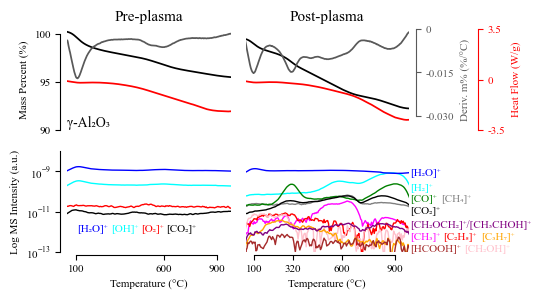

In [9]:
# Use Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams['font.size'] = 10

# Set the size of the figure in inches (1 inch = 25.4 mm)
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(140/25.4, 78.75/25.4),
    
)

# Now, axes is a 2x2 array
ax1a = axes[0, 0]
ax1b = ax1a.twinx()
ax1c = ax1a.twinx()
ax2a = axes[0, 1]
ax2b = ax2a.twinx()
ax2c = ax2a.twinx()
ax3a = axes[1, 0]
ax4a = axes[1, 1]

# Set the title for the left column of plots
ax1a.set_title(label='Pre-plasma', fontsize=11)

# Set the title for the right column of plots
ax2a.set_title(label='Post-plasma', fontsize=11)


# Despine the ax1 plot for a cleaner look
sns.despine(
    ax=ax1a,
    left=False, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax1b,
    left=True, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax1c,
    left=True, top=True, right=True, bottom=True
)

# Create a line plot on ax1a
# for the pre-plasma gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color=(0/255, 0/255, 0/255),
    linewidth=1.25,
    legend=False,
    ax=ax1a
)

# ax1a x-axis settings
ax1a.xaxis.set_visible(False)
ax1a.set_xlim([50, 980])

# ax1a y-axis settings
ax1a.spines['left'].set_position(('outward', 5)) 
ax1a.spines['left'].set_bounds(90, 100)
ax1a.set_ylabel(ylabel='Mass Percent (%)', fontsize=8)
ax1a.set_yticks(ticks=[90, 95, 100])
ax1a.tick_params(axis='y', labelsize=8)

# Create a line plot on ax1b
# for the pre-plasma gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color=((0*alpha+255*(1-alpha))/255,
        (0*alpha+255*(1-alpha))/255,
        (0*alpha+255*(1-alpha))/255),
    linewidth=1.25,
    legend=False,
    ax=ax1b
)

# ax1b x-axis settings
ax1b.xaxis.set_visible(False)
ax1b.set_xlim(ax1a.get_xlim())

# ax1b y-axis settings
ax1b.yaxis.set_visible(False)
ax1b.set_ylim([-0.035, 0])

# Create a line plot on ax1c
# for the pre-plasma gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax1c
)

# ax1c x-axis settings
ax1c.xaxis.set_visible(False)
ax1c.set_xlim(ax1a.get_xlim())

# ax1c y-axis settings
ax1c.yaxis.set_visible(False)
ax1c.set_ylim([-3.5, 3.5])

# Define the material label manually
ax1a.annotate(
    text="γ-Al₂O₃",
    xy=(50, 90.3),
    xytext=(0, 0),
    textcoords='offset points',
    fontsize=10,
    color=(0/255, 0/255, 0/255),
    zorder=5
)


# Despine ax2
sns.despine(
    ax=ax2a,
    right=True, left=True, top=True, bottom=True
)
sns.despine(
    ax=ax2b,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 5}
)
sns.despine(
    ax=ax2c,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 50}
)

# Create a line plot on the first ax2 y-axis
# for the post-plasma gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color=(0/255, 0/255, 0/255),
    linewidth=1.25,
    legend=False,
    ax=ax2a
)

# ax2a x-axis settings
ax2a.xaxis.set_visible(False)
ax2a.spines['bottom'].set_bounds(100, 900)
ax2a.spines['bottom'].set_position(('outward', 2))
ax2a.set_xlabel(None)
ax2a.set_xlim([50, 980])
ax2a.set_xticks(ticks=[100, 320, 600, 900])
ax2a.tick_params(axis='x', labelsize=8)

# ax2a y-axis settings
ax2a.yaxis.set_visible(False)
ax2a.set_ylim([90, 101])

# Create a line plot on the second y-axis ax2
# for the post-plasma gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color=((0*alpha+255*(1-alpha))/255,
           (0*alpha+255*(1-alpha))/255,
           (0*alpha+255*(1-alpha))/255),
    linewidth=1.25,
    legend=False,
    ax=ax2b
)

# ax2b x-axis settings
ax2b.xaxis.set_visible(False)
ax2b.set_xlim(ax2a.get_xlim())

# ax2b y-axis settings
ax2b.spines['right'].set_bounds(-0.03, 0)
ax2b.spines['right'].set_color(((0*alpha+255*(1-alpha))/255,
                       (0*alpha+255*(1-alpha))/255,
                       (0*alpha+255*(1-alpha))/255))
ax2b.set_ylabel(
    ylabel='Deriv. m% (%/°C)',
    fontsize=8,
    color=((0*alpha+255*(1-alpha))/255,
            (0*alpha+255*(1-alpha))/255,
            (0*alpha+255*(1-alpha))/255)
)
ax2b.set_ylim(ax1b.get_ylim())
ax2b.set_yticks(
    ticks=[0, -0.015, -0.03],
    labels=['0', '-0.015', '-0.030']
)
ax2b.tick_params(
    axis='y',
    labelcolor=((0*alpha+255*(1-alpha))/255,
                (0*alpha+255*(1-alpha))/255,
                (0*alpha+255*(1-alpha))/255),
    color=((0*alpha+255*(1-alpha))/255,
                (0*alpha+255*(1-alpha))/255,
                (0*alpha+255*(1-alpha))/255),
    direction='out',
    right=True,
    labelsize=8
)

# Create a line plot on the third ax2 y-axis
# for the post-plasma gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax2c
)

# ax2c x-axis settings
ax2c.xaxis.set_visible(False)
ax2c.set_xlim(ax2a.get_xlim())

# ax2c y-axis settings
ax2c.spines['right'].set_color('red')
ax2c.spines['right'].set_bounds(-3.5, 3.5)
ax2c.set_ylabel(ylabel='Heat Flow (W/g)', fontsize=8, color='red')
ax2c.set_ylim([-3.5, 3.5])
ax2c.set_yticks(ticks=[-3.5, 0, 3.5],
                labels=['-3.5', '0', '3.5'])
ax2c.tick_params(
    axis='y',
    labelcolor='red',
    color='red',
    direction='out',
    right=True,
    labelsize=8
)


# Despine the ax3 plot for a cleaner look
sns.despine(
    ax=ax3a,
    left=False, top=True, right=True, bottom=False
)

# Create a line plot on ax3a
# for the pre-plasma gamma-Al2O3 ms data
for mz, color in mz_list_pre:
    sns.lineplot(
        x='temp_sample_dC_gaussian',
        y=mz,
        data=tga_dsc_ms_Ar[
            (tga_dsc_ms_Ar['material']=='γ-Al₂O₃')
            & (tga_dsc_ms_Ar['plasma']=='pre-plasma')
            ],
        color=color,
        linewidth=1,
        legend=False,
        ax=ax3a
    )

# ax3a x-axis settings
ax3a.spines['bottom'].set_bounds(100, 900)
ax3a.spines['bottom'].set_position(('outward', 2))
ax3a.set_xlabel(xlabel='Temperature (°C)', fontsize=8)
ax3a.set_xlim([50, 980])
ax3a.set_xticks([100, 600, 900])
ax3a.tick_params(axis='x', labelsize=8)

# ax3a y-axis settings
ax3a.spines['left'].set_position(('outward', 5))
ax3a.set_ylabel(ylabel='Log MS Intensity (a.u.)', fontsize=8)
ax3a.set_ylim([1e-13, 1e-8])
ax3a.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=8)
ax3a.set_yscale('log')

# List of compound labels, colors and position for the ax4a plot
compound_list = [
    ('[H₂O]⁺','blue', (100, 1e-12, 1)),
    ('[OH]⁺', 'cyan', (100, 1e-12, 25)),
    ('[O₂]⁺', 'red', (100, 1e-12, 47)),
    ('[CO₂]⁺','black', (100, 1e-12, 65))
]

# Add compound labels to the ax4a plot
for compound, color, (x,y, x_offset) in compound_list:
    ax3a.annotate(
        text=compound,
        xy=(x, y),
        xytext=(x_offset, 0),
        textcoords='offset points',
        fontsize=8,
        color=color,
        zorder=5
    )

# Despine the ax4 plot for a cleaner look
sns.despine(
    ax=ax4a,
    left=True, top=True, right=True, bottom=False
)

# Create a line plot on ax4a
# for the post-plasma gamma-Al2O3 ms data
for mz, color in mz_list_post:
    sns.lineplot(
        x='temp_sample_dC_gaussian',
        y=mz,
        data=tga_dsc_ms_Ar[
            (tga_dsc_ms_Ar['material']=='γ-Al₂O₃')
            & (tga_dsc_ms_Ar['plasma']=='post-plasma')
            ],
        color=color,
        linewidth=1,
        legend=False,
        ax=ax4a
    )

# ax4a x-axis settings
ax4a.spines['bottom'].set_bounds(100, 900)
ax4a.spines['bottom'].set_position(('outward', 2))
ax4a.set_xlabel(xlabel='Temperature (°C)', fontsize=8)
ax4a.set_xlim([50, 980])
ax4a.set_xticks([100, 320, 600, 900])
ax4a.tick_params(axis='x', labelsize=8)

# ax4a y-axis settings
ax4a.yaxis.set_visible(False)
ax4a.set_ylim(ax3a.get_ylim())
ax4a.set_yscale('log')

# List of compound labels, colors and position for the ax4a plot
compound_list = [
    ('[H₂O]⁺','blue', (980, 6e-10, 1)),
    ('[H₂]⁺', 'cyan', (980, 1e-10, 1)),
    ('[CH₄]⁺', 'grey', (980, 3e-11, 23)),
    ('[CO]⁺','green', (980, 3e-11, 1)),
    ('[CO₂]⁺','black', (980, 8e-12, 1)),
    ('[CH₃]⁺','magenta', (980, 4e-13, 1)),
    ('[C₂H₅]⁺', 'red', (980, 4e-13, 25)),
    ('[C₃H₇]⁺', 'orange', (980, 4e-13, 52)),
    ('[HCOOH]⁺', 'brown', (980, 1e-13, 1)),
    ('[CH₂OH]⁺', 'pink', (980, 1e-13, 40)),
    ('[CH₂OCH₂]⁺/[CH₃CHOH]⁺', 'purple', (980, 1.6e-12, 1)),
]

# Add compound labels to the ax4a plot
for compound, color, (x,y, x_offset) in compound_list:
    ax4a.annotate(
        text=compound,
        xy=(x, y),
        xytext=(x_offset, 0),
        textcoords='offset points',
        fontsize=8,
        color=color,
        zorder=5
    )

plt.tight_layout()
plt.savefig(
    r'C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_tga_ms_ar_al2o3.pdf'
)
plt.show()

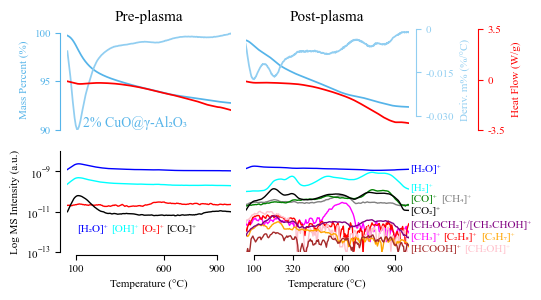

In [10]:
# Use Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams['font.size'] = 10

# Set the size of the figure in inches (1 inch = 25.4 mm)
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(140/25.4, 78.75/25.4),
    
)

# Now, axes is a 2x2 array
ax1a = axes[0, 0]
ax1b = ax1a.twinx()
ax1c = ax1a.twinx()
ax2a = axes[0, 1]
ax2b = ax2a.twinx()
ax2c = ax2a.twinx()
ax3a = axes[1, 0]
ax4a = axes[1, 1]

# Set the title for the left column of plots
ax1a.set_title(label='Pre-plasma', fontsize=11)

# Set the title for the right column of plots
ax2a.set_title(label='Post-plasma', fontsize=11)


# Despine the ax1 plot for a cleaner look
sns.despine(
    ax=ax1a,
    left=False, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax1b,
    left=True, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax1c,
    left=True, top=True, right=True, bottom=True
)

# Create a line plot on ax1a
# for the pre-plasma 2% CuO@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='2% CuO@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color=(86/255, 180/255, 233/255),
    linewidth=1.25,
    legend=False,
    ax=ax1a
)

# ax1a x-axis settings
ax1a.xaxis.set_visible(False)
ax1a.set_xlim([50, 980])

# ax1a y-axis settings
ax1a.spines['left'].set_position(('outward', 5))
ax1a.spines['left'].set_bounds(90, 100)
ax1a.spines['left'].set_color((86/255, 180/255, 233/255))
ax1a.set_ylabel(
    ylabel='Mass Percent (%)',
    fontsize=8,
    color=(86/255, 180/255, 233/255)
)
ax1a.set_yticks(ticks=[90, 95, 100])
ax1a.tick_params(
    axis='y',
    labelsize=8,
    color=(86/255, 180/255, 233/255),
    labelcolor=(86/255, 180/255, 233/255)
)

# Create a line plot on ax1b
# for the pre-plasma 2% CuO@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='2% CuO@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color=((86*alpha+255*(1-alpha))/255,
           (180*alpha+255*(1-alpha))/255,
           (233*alpha+255*(1-alpha))/255),
    linewidth=1.25,
    legend=False,
    ax=ax1b
)

# ax1b x-axis settings
ax1b.xaxis.set_visible(False)
ax1b.set_xlim(ax1a.get_xlim())

# ax1b y-axis settings
ax1b.yaxis.set_visible(False)
ax1b.set_ylim([-0.035, 0])

# Create a line plot on ax1c
# for the pre-plasma 2% CuO@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='2% CuO@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax1c
)

# ax1c x-axis settings
ax1c.xaxis.set_visible(False)
ax1c.set_xlim(ax1a.get_xlim())

# ax1c y-axis settings
ax1c.yaxis.set_visible(False)
ax1c.set_ylim([-3.5, 3.5])

# Define the material label manually
ax1a.annotate(
    text="2% CuO@γ-Al₂O₃",
    xy=(140, 90.3),
    xytext=(0, 0),
    textcoords='offset points',
    fontsize=10,
    color=(86/255, 180/255, 233/255),
    zorder=5
)


# Despine ax2
sns.despine(
    ax=ax2a,
    right=True, left=True, top=True, bottom=True
)
sns.despine(
    ax=ax2b,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 5}
)
sns.despine(
    ax=ax2c,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 50}
)

# Create a line plot on the first ax2 y-axis
# for the post-plasma 2% CuO@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='2% CuO@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color=(86/255, 180/255, 233/255),
    linewidth=1.25,
    legend=False,
    ax=ax2a
)

# ax2a x-axis settings
ax2a.xaxis.set_visible(False)
ax2a.set_xlim([50, 980])

# ax2a y-axis settings
ax2a.yaxis.set_visible(False)
ax2a.set_ylim([90, 101])

# Create a line plot on the second y-axis ax2
# for the post-plasma 2% CuO@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='2% CuO@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color=((86*alpha+255*(1-alpha))/255,
           (180*alpha+255*(1-alpha))/255,
           (233*alpha+255*(1-alpha))/255),
    linewidth=1.25,
    legend=False,
    ax=ax2b
)

# ax2b x-axis settings
ax2b.xaxis.set_visible(False)
ax2b.set_xlim(ax2a.get_xlim())

# ax2b y-axis settings
ax2b.spines['right'].set_bounds(-0.03, 0)
ax2b.spines['right'].set_color(((86*alpha+255*(1-alpha))/255,
                                (180*alpha+255*(1-alpha))/255,
                                (233*alpha+255*(1-alpha))/255))
ax2b.set_ylabel(ylabel='Deriv. m% (%/°C)',
                fontsize=8,
                color=((86*alpha+255*(1-alpha))/255,
                       (180*alpha+255*(1-alpha))/255,
                       (233*alpha+255*(1-alpha))/255))
ax2b.set_ylim(ax1b.get_ylim())
ax2b.set_yticks(ticks=[0, -0.015, -0.03],
                labels=['0', '-0.015', '-0.030'])
ax2b.tick_params(axis='y',
                 labelcolor=((86*alpha+255*(1-alpha))/255,
                             (180*alpha+255*(1-alpha))/255,
                             (233*alpha+255*(1-alpha))/255),
                 color=((86*alpha+255*(1-alpha))/255,
                        (180*alpha+255*(1-alpha))/255,
                        (233*alpha+255*(1-alpha))/255),
                 direction='out',
                 right=True,
                 labelsize=8)

# Create a line plot on the third ax2 y-axis
# for the post-plasma 2% CuO@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='2% CuO@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax2c
)

# ax2c x-axis settings
ax2c.xaxis.set_visible(False)
ax2c.set_xlim(ax2a.get_xlim())

# ax2c y-axis settings
ax2c.spines['right'].set_color('red')
ax2c.spines['right'].set_bounds(-3.5, 3.5)
ax2c.set_ylabel(ylabel='Heat Flow (W/g)', fontsize=8, color='red')
ax2c.set_ylim([-3.5, 3.5])
ax2c.set_yticks(ticks=[-3.5, 0, 3.5], labels=['-3.5', '0', '3.5'])
ax2c.tick_params(
    axis='y',
    labelcolor='red',
    color='red',
    direction='out',
    right=True,
    labelsize=8
)


# Despine the ax3 plot for a cleaner look
sns.despine(
    ax=ax3a,
    left=False, top=True, right=True, bottom=False
)

# Create a line plot on ax3a
# for the pre-plasma 2% CuO@gamma-Al2O3 ms data
for mz, color in mz_list_pre:
    sns.lineplot(
        x='temp_sample_dC_gaussian',
        y=mz,
        data=tga_dsc_ms_Ar[
            (tga_dsc_ms_Ar['material']=='2% CuO@γ-Al₂O₃')
            & (tga_dsc_ms_Ar['plasma']=='pre-plasma')
            ],
        color=color,
        linewidth=1,
        legend=False,
        ax=ax3a
    )

# ax3a x-axis settings
ax3a.spines['bottom'].set_bounds(100, 900)
ax3a.spines['bottom'].set_position(('outward', 2))
ax3a.set_xlabel(xlabel='Temperature (°C)', fontsize=8)
ax3a.set_xlim([50, 980])
ax3a.set_xticks(ticks=[100, 600, 900])
ax3a.tick_params(axis='x', labelsize=8)

# ax3a y-axis settings
ax3a.spines['left'].set_position(('outward', 5))
ax3a.set_ylabel(ylabel='Log MS Intensity (a.u.)', fontsize=8)
ax3a.set_ylim([1e-13, 1e-8])
ax3a.tick_params(
    axis='y',
    which='both',
    left=True,
    labelleft=True,
    labelsize=8
)
ax3a.set_yscale('log')

# List of compound labels, colors and position for the ax4a plot
compound_list = [
    ('[H₂O]⁺','blue', (100, 1e-12, 1)),
    ('[OH]⁺', 'cyan', (100, 1e-12, 25)),
    ('[O₂]⁺', 'red', (100, 1e-12, 47)),
    ('[CO₂]⁺','black', (100, 1e-12, 65))
]

# Add compound labels to the ax4a plot
for compound, color, (x,y, x_offset) in compound_list:
    ax3a.annotate(
        text=compound,
        xy=(x, y),
        xytext=(x_offset, 0),
        textcoords='offset points',
        fontsize=8,
        color=color,
        zorder=5
    )

# Despine the ax4 plot for a cleaner look
sns.despine(
    ax=ax4a,
    left=True, top=True, right=True, bottom=False
)

# Create a line plot on ax4a
# for the post-plasma 2% CuO@gamma-Al2O3 ms data
for mz, color in mz_list_post:
    sns.lineplot(
        x='temp_sample_dC_gaussian',
        y=mz,
        data=tga_dsc_ms_Ar[
            (tga_dsc_ms_Ar['material']=='2% CuO@γ-Al₂O₃')
            & (tga_dsc_ms_Ar['plasma']=='post-plasma')
            ],
        color=color,
        linewidth=1,
        legend=False,
        ax=ax4a
    )

# ax4a x-axis settings
ax4a.spines['bottom'].set_bounds(100, 900)
ax4a.spines['bottom'].set_position(('outward', 2)) 
ax4a.set_xlabel(xlabel='Temperature (°C)', fontsize=8)
ax4a.set_xlim([50, 980])
ax4a.set_xticks(ticks=[100, 320, 600, 900])
ax4a.tick_params(axis='x', labelsize=8)

# ax4a y-axis settings
ax4a.yaxis.set_visible(False)
ax4a.set_ylim(ax3a.get_ylim())
ax4a.set_yscale('log')

# List of compound labels, colors and position for the ax4a plot
compound_list = [
    ('[H₂O]⁺','blue', (980, 9e-10, 1)),
    ('[H₂]⁺', 'cyan', (980, 1e-10, 1)),
    ('[CH₄]⁺', 'grey', (980, 3e-11, 23)),
    ('[CO]⁺','green', (980, 3e-11, 1)),
    ('[CO₂]⁺','black', (980, 8e-12, 1)),
    ('[CH₃]⁺','magenta', (980, 4e-13, 1)),
    ('[C₂H₅]⁺', 'red', (980, 4e-13, 25)),
    ('[C₃H₇]⁺', 'orange', (980, 4e-13, 52)),
    ('[HCOOH]⁺', 'brown', (980, 1e-13, 1)),
    ('[CH₂OH]⁺', 'pink', (980, 1e-13, 40)),
    ('[CH₂OCH₂]⁺/[CH₃CHOH]⁺', 'purple', (980, 1.6e-12, 1)),
]

# Add compound labels to the ax4a plot
for compound, color, (x,y, x_offset) in compound_list:
    ax4a.annotate(
        text=compound,
        xy=(x, y),
        xytext=(x_offset, 0),
        textcoords='offset points',
        fontsize=8,
        color=color,
        zorder=5
    )


plt.tight_layout()
plt.savefig(
    r'C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_tga_ms_ar_cuo_02.pdf'
)
plt.show()

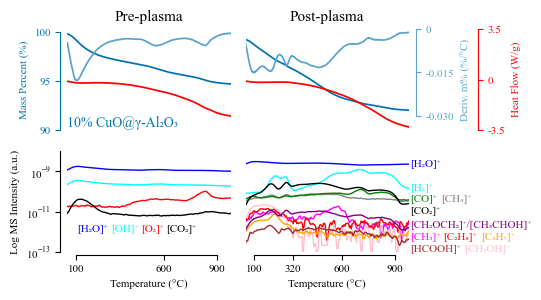

In [11]:
# Use Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams['font.size'] = 10

# Set the size of the figure in inches (1 inch = 25.4 mm)
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(140/25.4, 78.75/25.4),
    
)

# Now, axes is a 2x2 array
ax1a = axes[0, 0]
ax1b = ax1a.twinx()
ax1c = ax1a.twinx()
ax2a = axes[0, 1]
ax2b = ax2a.twinx()
ax2c = ax2a.twinx()
ax3a = axes[1, 0]
ax4a = axes[1, 1]

# Set the title for the left column of plots
ax1a.set_title(label='Pre-plasma', fontsize=11)

# Set the title for the right column of plots
ax2a.set_title(label='Post-plasma', fontsize=11)


# Despine the ax1 plot for a cleaner look
sns.despine(
    ax=ax1a,
    left=False, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax1b,
    left=True, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax1c,
    left=True, top=True, right=True, bottom=True
)

# Create a line plot on ax1a
# for the pre-plasma 10% CuO@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='10% CuO@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color=(0/255, 114/255, 178/255),
    linewidth=1.25,
    legend=False,
    ax=ax1a
)

# ax1a x-axis settings
ax1a.xaxis.set_visible(False)
ax1a.set_xlim([50, 980])

# ax1a y-axis settings
ax1a.spines['left'].set_position(('outward', 5))
ax1a.spines['left'].set_bounds(90, 100)
ax1a.spines['left'].set_color((0/255, 114/255, 178/255))
ax1a.set_ylabel(
    ylabel='Mass Percent (%)',
    fontsize=8,
    color=(0/255, 114/255, 178/255)
)
ax1a.set_yticks(ticks=[90, 95, 100])
ax1a.tick_params(
    axis='y',
    labelsize=8,
    color=(0/255, 114/255, 178/255),
    labelcolor=(0/255, 114/255, 178/255)
)

# Create a line plot on ax1b
# for the pre-plasma 10% CuO@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='10% CuO@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color=((0 * alpha + 255 * (1 - alpha)) / 255,
           (114 * alpha + 255 * (1 - alpha)) / 255,
           (178 * alpha + 255 * (1 - alpha)) / 255),
    linewidth=1.25,
    legend=False,
    ax=ax1b
)

# ax1b x-axis settings
ax1b.xaxis.set_visible(False)
ax1b.set_xlim(ax1a.get_xlim())

# ax1b y-axis settings
ax1b.yaxis.set_visible(False)
ax1b.set_ylim([-0.035, 0])

# Create a line plot on ax1c
# for the pre-plasma 10% CuO@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='10% CuO@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax1c
)

# ax1c x-axis settings
ax1c.xaxis.set_visible(False)
ax1c.set_xlim(ax1a.get_xlim())

# ax1c y-axis settings
ax1c.yaxis.set_visible(False)
ax1c.set_ylim([-3.5, 3.5])

# Define the material label manually
ax1a.annotate(
    text="10% CuO@γ-Al₂O₃",
    xy=(50, 90.3),
    xytext=(0, 0),
    textcoords='offset points',
    fontsize=10,
    color=(0/255, 114/255, 178/255),
    zorder=5
)


# Despine ax2
sns.despine(
    ax=ax2a,
    right=True, left=True, top=True, bottom=True
)
sns.despine(
    ax=ax2b,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 5}
)
sns.despine(
    ax=ax2c,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 50}
)

# Create a line plot on the first ax2 y-axis
# for the post-plasma 10% CuO@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='10% CuO@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color=(0/255, 114/255, 178/255),
    linewidth=1.25,
    legend=False,
    ax=ax2a
)

# ax2a x-axis settings
ax2a.xaxis.set_visible(False)
ax2a.set_xlim([50, 980])

# ax2a y-axis settings
ax2a.yaxis.set_visible(False)
ax2a.set_ylim([90, 101])

# Create a line plot on the second y-axis ax2
# for the post-plasma 10% CuO@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='10% CuO@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color=((0 * alpha + 255 * (1 - alpha)) / 255,
           (114 * alpha + 255 * (1 - alpha)) / 255,
           (178 * alpha + 255 * (1 - alpha)) / 255),
    linewidth=1.25,
    legend=False,
    ax=ax2b
)

# ax2b x-axis settings
ax2b.xaxis.set_visible(False)
ax2b.set_xlim(ax2a.get_xlim())

# ax2b y-axis settings
ax2b.spines['right'].set_bounds(-0.03, 0)
ax2b.spines['right'].set_color(((0 * alpha + 255 * (1 - alpha)) / 255,
                                (114 * alpha + 255 * (1 - alpha)) / 255,
                                (178 * alpha + 255 * (1 - alpha)) / 255))
ax2b.set_ylabel(
    ylabel='Deriv. m% (%/°C)',
    fontsize=8,
    color=((0 * alpha + 255 * (1 - alpha)) / 255,
            (114 * alpha + 255 * (1 - alpha)) / 255,
            (178 * alpha + 255 * (1 - alpha)) / 255)
)
ax2b.set_ylim(ax1b.get_ylim())
ax2b.set_yticks(
    ticks=[0, -0.015, -0.03],
    labels=['0', '-0.015', '-0.030']
)
ax2b.tick_params(
    axis='y',
    labelcolor=((0 * alpha + 255 * (1 - alpha)) / 255,
                (114 * alpha + 255 * (1 - alpha)) / 255,
                (178 * alpha + 255 * (1 - alpha)) / 255),
    color=((0 * alpha + 255 * (1 - alpha)) / 255,
           (114 * alpha + 255 * (1 - alpha)) / 255,
           (178 * alpha + 255 * (1 - alpha)) / 255),
    direction='out',
    right=True,
    labelsize=8
)

# Create a line plot on the third ax2 y-axis
# for the post-plasma 10% CuO@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='10% CuO@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax2c
)

# ax2c x-axis settings
ax2c.xaxis.set_visible(False)
ax2c.set_xlim(ax2a.get_xlim())

# ax2c y-axis settings
ax2c.spines['right'].set_color('red')
ax2c.spines['right'].set_bounds(-3.5, 3.5)
ax2c.set_ylabel(ylabel='Heat Flow (W/g)', fontsize=8, color='red')
ax2c.set_ylim([-3.5, 3.5])
ax2c.set_yticks(ticks=[-3.5, 0, 3.5],
                labels=['-3.5', '0', '3.5'])
ax2c.tick_params(
    axis='y',
    labelcolor='red',
    color='red',
    direction='out',
    right=True,
    labelsize=8
)


# Despine the ax3 plot for a cleaner look
sns.despine(
    ax=ax3a,
    left=False, top=True, right=True, bottom=False
)

# Create a line plot on ax3a
# for the pre-plasma 10% CuO@gamma-Al2O3 ms data
for mz, color in mz_list_pre:
    sns.lineplot(
        x='temp_sample_dC_gaussian',
        y=mz,
        data=tga_dsc_ms_Ar[
            (tga_dsc_ms_Ar['material']=='10% CuO@γ-Al₂O₃')
            & (tga_dsc_ms_Ar['plasma']=='pre-plasma')
            ],
        color=color,
        linewidth=1,
        legend=False,
        ax=ax3a
    )

# ax3a x-axis settings
ax3a.spines['bottom'].set_bounds(100, 900)
ax3a.spines['bottom'].set_position(('outward', 2))
ax3a.set_xlabel(xlabel='Temperature (°C)', fontsize=8)
ax3a.set_xlim([50, 980])
ax3a.set_xticks(ticks=[100, 600, 900])
ax3a.tick_params(axis='x', labelsize=8)

# ax3a y-axis settings
ax3a.spines['left'].set_position(('outward', 5))
ax3a.set_ylabel(ylabel='Log MS Intensity (a.u.)', fontsize=8)
ax3a.set_ylim([1e-13, 1e-8])
ax3a.tick_params(
    axis='y',
    which='both',
    left=True,
    labelleft=True,
    labelsize=8
)
ax3a.set_yscale('log')

# List of compound labels, colors and position for the ax4a plot
compound_list = [
    ('[H₂O]⁺','blue', (100, 1e-12, 1)),
    ('[OH]⁺', 'cyan', (100, 1e-12, 25)),
    ('[O₂]⁺', 'red', (100, 1e-12, 47)),
    ('[CO₂]⁺','black', (100, 1e-12, 65))
]

# Add compound labels to the ax4a plot
for compound, color, (x,y, x_offset) in compound_list:
    ax3a.annotate(
        text=compound,
        xy=(x, y),
        xytext=(x_offset, 0),
        textcoords='offset points',
        fontsize=8,
        color=color,
        zorder=5
    )

# Despine the ax4 plot for a cleaner look
sns.despine(
    ax=ax4a,
    left=True, top=True, right=True, bottom=False
)

# Create a line plot on ax4a
# for the post-plasma 10% CuO@gamma-Al2O3 ms data
for mz, color in mz_list_post:
    sns.lineplot(
        x='temp_sample_dC_gaussian',
        y=mz,
        data=tga_dsc_ms_Ar[
            (tga_dsc_ms_Ar['material']=='10% CuO@γ-Al₂O₃')
            & (tga_dsc_ms_Ar['plasma']=='post-plasma')
            ],
        color=color,
        linewidth=1,
        legend=False,
        ax=ax4a
    )

# ax4a x-axis settings
ax4a.spines['bottom'].set_bounds(100, 900)
ax4a.spines['bottom'].set_position(('outward', 2)) 
ax4a.set_xlabel(xlabel='Temperature (°C)', fontsize=8)
ax4a.set_xlim([50, 980])
ax4a.set_xticks(ticks=[100, 320, 600, 900])
ax4a.tick_params(axis='x', labelsize=8)

# ax4a y-axis settings
ax4a.yaxis.set_visible(False)
ax4a.set_ylim(ax3a.get_ylim())
ax4a.set_yscale('log')

# List of compound labels, colors and position for the ax4a plot
compound_list = [
    ('[H₂O]⁺','blue', (980, 1.6e-9, 1)),
    ('[H₂]⁺', 'cyan', (980, 1e-10, 1)),
    ('[CH₄]⁺', 'grey', (980, 3e-11, 23)),
    ('[CO]⁺','green', (980, 3e-11, 1)),
    ('[CO₂]⁺','black', (980, 8e-12, 1)),
    ('[CH₃]⁺','magenta', (980, 4e-13, 1)),
    ('[C₂H₅]⁺', 'red', (980, 4e-13, 25)),
    ('[C₃H₇]⁺', 'orange', (980, 4e-13, 52)),
    ('[HCOOH]⁺', 'brown', (980, 1e-13, 1)),
    ('[CH₂OH]⁺', 'pink', (980, 1e-13, 40)),
    ('[CH₂OCH₂]⁺/[CH₃CHOH]⁺', 'purple', (980, 1.6e-12, 1)),
]

# Add compound labels to the ax4a plot
for compound, color, (x,y, x_offset) in compound_list:
    ax4a.annotate(
        text=compound,
        xy=(x, y),
        xytext=(x_offset, 0),
        textcoords='offset points',
        fontsize=8,
        color=color,
        zorder=5
    )

plt.tight_layout()
plt.savefig(
    r'C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_tga_ms_ar_cuo_10.pdf'
)
plt.show()

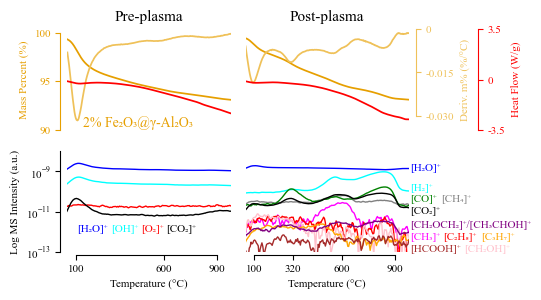

In [12]:
# Use Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams['font.size'] = 10

# Set the size of the figure in inches (1 inch = 25.4 mm)
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(140/25.4, 78.75/25.4),
    
)

# Now, axes is a 2x2 array
ax1a = axes[0, 0]
ax1b = ax1a.twinx()
ax1c = ax1a.twinx()
ax2a = axes[0, 1]
ax2b = ax2a.twinx()
ax2c = ax2a.twinx()
ax3a = axes[1, 0]
ax4a = axes[1, 1]

# Set the title for the left column of plots
ax1a.set_title(label='Pre-plasma', fontsize=11)

# Set the title for the right column of plots
ax2a.set_title(label='Post-plasma', fontsize=11)


# Despine the ax1 plot for a cleaner look
sns.despine(
    ax=ax1a,
    left=False, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax1b,
    left=True, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax1c,
    left=True, top=True, right=True, bottom=True
)

# Create a line plot on ax1a
# for the pre-plasma 2% Fe₂O₃@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='2% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color=(230/255, 159/255, 0/255),
    linewidth=1.25,
    legend=False,
    ax=ax1a
)

# ax1a x-axis settings
ax1a.xaxis.set_visible(False)
ax1a.set_xlim([50, 980])

# ax1a y-axis settings
ax1a.spines['left'].set_position(('outward', 5))
ax1a.spines['left'].set_bounds(90, 100)
ax1a.spines['left'].set_color((230/255, 159/255, 0/255))
ax1a.set_ylabel(
    ylabel='Mass Percent (%)',
    fontsize=8,
    color=(230/255, 159/255, 0/255)
)
ax1a.set_yticks(ticks=[90, 95, 100])
ax1a.tick_params(
    axis='y',
    labelsize=8,
    color=(230/255, 159/255, 0/255),
    labelcolor=(230/255, 159/255, 0/255)
)

# Create a line plot on ax1b
# for the pre-plasma 2% Fe₂O₃@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='2% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color=((230 * alpha + 255 * (1 - alpha)) / 255,
           (159 * alpha + 255 * (1 - alpha)) / 255,
           (0 * alpha + 255 * (1 - alpha)) / 255),
    linewidth=1.25,
    legend=False,
    ax=ax1b
)

# ax1b x-axis settings
ax1b.xaxis.set_visible(False)
ax1b.set_xlim(ax1a.get_xlim())

# ax1b y-axis settings
ax1b.yaxis.set_visible(False)
ax1b.set_ylim([-0.035, 0])

# Create a line plot on ax1c
# for the pre-plasma 2% Fe₂O₃@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='2% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax1c
)

# ax1c x-axis settings
ax1c.xaxis.set_visible(False)
ax1c.set_xlim(ax1a.get_xlim())

# ax1c y-axis settings
ax1c.yaxis.set_visible(False)
ax1c.set_ylim([-3.5, 3.5])

# Define the material label manually
ax1a.annotate(
    text="2% Fe₂O₃@γ-Al₂O₃",
    xy=(140, 90.3),
    xytext=(0, 0),
    textcoords='offset points',
    fontsize=10,
    color=(230/255, 159/255, 0/255),
    zorder=5
)


# Despine ax2
sns.despine(
    ax=ax2a,
    right=True, left=True, top=True, bottom=True
)
sns.despine(
    ax=ax2b,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 5}
)
sns.despine(
    ax=ax2c,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 50}
)

# Create a line plot on the first ax2 y-axis
# for the post-plasma 2% Fe₂O₃@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='2% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color=(230/255, 159/255, 0/255),
    linewidth=1.25,
    legend=False,
    ax=ax2a
)

# ax2a x-axis settings
ax2a.xaxis.set_visible(False)
ax2a.set_xlim([50, 980])

# ax2a y-axis settings
ax2a.yaxis.set_visible(False)
ax2a.set_ylim([90, 101])

# Create a line plot on the second y-axis ax2
# for the post-plasma 2% Fe₂O₃@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='2% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color=((230 * alpha + 255 * (1 - alpha)) / 255,
           (159 * alpha + 255 * (1 - alpha)) / 255,
           (0 * alpha + 255 * (1 - alpha)) / 255),
    linewidth=1.25,
    legend=False,
    ax=ax2b
)

# ax2b x-axis settings
ax2b.xaxis.set_visible(False)
ax2b.set_xlim(ax2a.get_xlim())

# ax2b y-axis settings
ax2b.spines['right'].set_bounds(-0.03, 0)
ax2b.spines['right'].set_color(((230 * alpha + 255 * (1 - alpha)) / 255,
                                (159 * alpha + 255 * (1 - alpha)) / 255,
                                (0 * alpha + 255 * (1 - alpha)) / 255))
ax2b.set_ylabel(
    ylabel='Deriv. m% (%/°C)',
    fontsize=8,
    color=((230 * alpha + 255 * (1 - alpha)) / 255,
           (159 * alpha + 255 * (1 - alpha)) / 255,
           (0 * alpha + 255 * (1 - alpha)) / 255)
)
ax2b.set_ylim(ax1b.get_ylim())
ax2b.set_yticks(
    ticks=[0, -0.015, -0.03],
    labels=['0', '-0.015', '-0.030']
)
ax2b.tick_params(
    axis='y',
    labelcolor=((230 * alpha + 255 * (1 - alpha)) / 255,
                (159 * alpha + 255 * (1 - alpha)) / 255,
                (0 * alpha + 255 * (1 - alpha)) / 255),
    color=((230 * alpha + 255 * (1 - alpha)) / 255,
           (159 * alpha + 255 * (1 - alpha)) / 255,
           (0 * alpha + 255 * (1 - alpha)) / 255),
    direction='out',
    right=True,
    labelsize=8
)

# Create a line plot on the third ax2 y-axis
# for the post-plasma 2% Fe₂O₃@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='2% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax2c
)

# ax2c x-axis settings
ax2c.xaxis.set_visible(False)
ax2c.set_xlim(ax2a.get_xlim())

# ax2c y-axis settings
ax2c.spines['right'].set_color('red')
ax2c.spines['right'].set_bounds(-3.5, 3.5)
ax2c.set_ylabel(ylabel='Heat Flow (W/g)', fontsize=8, color='red')
ax2c.set_ylim([-3.5, 3.5])
ax2c.set_yticks(ticks=[-3.5, 0, 3.5],
                labels=['-3.5', '0', '3.5'])
ax2c.tick_params(
    axis='y',
    labelcolor='red',
    color='red',
    direction='out',
    right=True,
    labelsize=8
)


# Despine the ax3 plot for a cleaner look
sns.despine(
    ax=ax3a,
    left=False, top=True, right=True, bottom=False
)

# Create a line plot on ax3a
# for the pre-plasma 2% Fe₂O₃@gamma-Al2O3 ms data
for mz, color in mz_list_pre:
    sns.lineplot(
        x='temp_sample_dC_gaussian',
        y=mz,
        data=tga_dsc_ms_Ar[
            (tga_dsc_ms_Ar['material']=='2% Fe₂O₃@γ-Al₂O₃')
            & (tga_dsc_ms_Ar['plasma']=='pre-plasma')
            ],
        color=color,
        linewidth=1,
        legend=False,
        ax=ax3a
    )

# ax3a x-axis settings
ax3a.spines['bottom'].set_bounds(100, 900)
ax3a.spines['bottom'].set_position(('outward', 2))
ax3a.set_xlabel(xlabel='Temperature (°C)', fontsize=8)
ax3a.set_xlim([50, 980])
ax3a.set_xticks(ticks=[100, 600, 900])
ax3a.tick_params(axis='x', labelsize=8)

# ax3a y-axis settings
ax3a.spines['left'].set_position(('outward', 5))
ax3a.set_ylim([1e-13, 1e-8])
ax3a.set_ylabel(ylabel='Log MS Intensity (a.u.)', fontsize=8)
ax3a.tick_params(
    axis='y',
    which='both',
    left=True,
    labelleft=True,
    labelsize=8
)
ax3a.set_yscale('log')

# List of compound labels, colors and position for the ax4a plot
compound_list = [
    ('[H₂O]⁺','blue', (100, 1e-12, 1)),
    ('[OH]⁺', 'cyan', (100, 1e-12, 25)),
    ('[O₂]⁺', 'red', (100, 1e-12, 47)),
    ('[CO₂]⁺','black', (100, 1e-12, 65))
]

# Add compound labels to the ax4a plot
for compound, color, (x,y, x_offset) in compound_list:
    ax3a.annotate(
        text=compound,
        xy=(x, y),
        xytext=(x_offset, 0),
        textcoords='offset points',
        fontsize=8,
        color=color,
        zorder=5
    )

# Despine the ax4 plot for a cleaner look
sns.despine(
    ax=ax4a,
    left=True, top=True, right=True, bottom=False
)

# Create a line plot on ax4a
# for the post-plasma 2% Fe₂O₃@gamma-Al2O3 ms data
for mz, color in mz_list_post:
    sns.lineplot(
        x='temp_sample_dC_gaussian',
        y=mz,
        data=tga_dsc_ms_Ar[
            (tga_dsc_ms_Ar['material']=='2% Fe₂O₃@γ-Al₂O₃')
            & (tga_dsc_ms_Ar['plasma']=='post-plasma')
            ],
        color=color,
        linewidth=1,
        legend=False,
        ax=ax4a
    )

# ax4a x-axis settings
ax4a.spines['bottom'].set_bounds(100, 900)
ax4a.spines['bottom'].set_position(('outward', 2)) 
ax4a.set_xlabel(xlabel='Temperature (°C)', fontsize=8)
ax4a.set_xlim([50, 980])
ax4a.set_xticks(ticks=[100, 320, 600, 900])
ax4a.tick_params(axis='x', labelsize=8)

# ax4a y-axis settings
ax4a.yaxis.set_visible(False)
ax4a.set_ylim(ax3a.get_ylim())
ax4a.set_yscale('log')

# List of compound labels, colors and position for the ax4a plot
compound_list = [
    ('[H₂O]⁺','blue', (980, 1e-9, 1)),
    ('[H₂]⁺', 'cyan', (980, 1e-10, 1)),
    ('[CH₄]⁺', 'grey', (980, 3e-11, 23)),
    ('[CO]⁺','green', (980, 3e-11, 1)),
    ('[CO₂]⁺','black', (980, 8e-12, 1)),
    ('[CH₃]⁺','magenta', (980, 4e-13, 1)),
    ('[C₂H₅]⁺', 'red', (980, 4e-13, 25)),
    ('[C₃H₇]⁺', 'orange', (980, 4e-13, 52)),
    ('[HCOOH]⁺', 'brown', (980, 1e-13, 1)),
    ('[CH₂OH]⁺', 'pink', (980, 1e-13, 40)),
    ('[CH₂OCH₂]⁺/[CH₃CHOH]⁺', 'purple', (980, 1.6e-12, 1)),
]

# Add compound labels to the ax4a plot
for compound, color, (x,y, x_offset) in compound_list:
    ax4a.annotate(
        text=compound,
        xy=(x, y),
        xytext=(x_offset, 0),
        textcoords='offset points',
        fontsize=8,
        color=color,
        zorder=5
    )


plt.tight_layout()
plt.savefig(
    r'C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_tga_ms_ar_fe2o3_02.pdf'
)
plt.show()

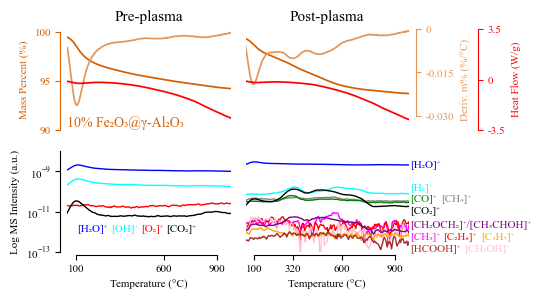

In [13]:
# Use Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams['font.size'] = 10

# Set the size of the figure in inches (1 inch = 25.4 mm)
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(140/25.4, 78.75/25.4),
    
)

# Now, axes is a 2x2 array
ax1a = axes[0, 0]
ax1b = ax1a.twinx()
ax1c = ax1a.twinx()
ax2a = axes[0, 1]
ax2b = ax2a.twinx()
ax2c = ax2a.twinx()
ax3a = axes[1, 0]
ax4a = axes[1, 1]

# Set the title for the left column of plots
ax1a.set_title(label='Pre-plasma', fontsize=11)

# Set the title for the right column of plots
ax2a.set_title(label='Post-plasma', fontsize=11)


# Despine the ax1 plot for a cleaner look
sns.despine(
    ax=ax1a,
    left=False, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax1b,
    left=True, top=True, right=True, bottom=True
)
sns.despine(
    ax=ax1c,
    left=True, top=True, right=True, bottom=True
)

# Create a line plot on ax1a
# for the pre-plasma 10% Fe₂O₃@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='10% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color=(213/255, 94/255, 0/255),
    linewidth=1.25,
    legend=False,
    ax=ax1a
)

# ax1a x-axis settings
ax1a.xaxis.set_visible(False)
ax1a.set_xlim([50, 980])

# ax1a y-axis settings
ax1a.spines['left'].set_position(('outward', 5))
ax1a.spines['left'].set_bounds(90, 100)
ax1a.spines['left'].set_color((213/255, 94/255, 0/255))
ax1a.set_ylabel(
    ylabel='Mass Percent (%)',
    fontsize=8,
    color=(213/255, 94/255, 0/255)
)
ax1a.set_yticks(ticks=[90, 95, 100])
ax1a.tick_params(
    axis='y',
    labelsize=8,
    color=(213/255, 94/255, 0/255),
    labelcolor=(213/255, 94/255, 0/255)
)

# Create a line plot on ax1b
# for the pre-plasma 10% Fe₂O₃@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='10% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color=((213 * alpha + 255 * (1 - alpha)) / 255,
           (94 * alpha + 255 * (1 - alpha)) / 255,
           (0 * alpha + 255 * (1 - alpha)) / 255),
    linewidth=1.25,
    legend=False,
    ax=ax1b
)

# ax1b x-axis settings
ax1b.xaxis.set_visible(False)
ax1b.set_xlim(ax1a.get_xlim())

# ax1b y-axis settings
ax1b.yaxis.set_visible(False)
ax1b.set_ylim([-0.035, 0])

# Create a line plot on ax1c
# for the pre-plasma 10% Fe₂O₃@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='10% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='pre-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax1c
)

# ax1c x-axis settings
ax1c.xaxis.set_visible(False)
ax1c.set_xlim(ax1a.get_xlim())

# ax1c y-axis settings
ax1c.yaxis.set_visible(False)
ax1c.set_ylim([-3.5, 3.5])

# Define the material label manually
ax1a.annotate(
    text="10% Fe₂O₃@γ-Al₂O₃",
    xy=(50, 90.3),
    xytext=(0, 0),
    textcoords='offset points',
    fontsize=10,
    color=(213/255, 94/255, 0/255),
    zorder=5
)


# Despine ax2
sns.despine(
    ax=ax2a,
    right=True, left=True, top=True, bottom=True
)
sns.despine(
    ax=ax2b,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 5}
)
sns.despine(
    ax=ax2c,
    right=False, left=True, top=True, bottom=True,
    offset={'right': 50}
)

# Create a line plot on the first ax2 y-axis
# for the post-plasma 10% Fe₂O₃@gamma-Al2O3 tga data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='10% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color=(213/255, 94/255, 0/255),
    linewidth=1.25,
    legend=False,
    ax=ax2a
)

# ax2a x-axis settings
ax2a.xaxis.set_visible(False)
ax2a.set_xlim([50, 980])

# ax2a y-axis settings
ax2a.yaxis.set_visible(False)
ax2a.set_ylim([90, 101])

# Create a line plot on the second y-axis ax2
# for the post-plasma 10% Fe₂O₃@gamma-Al2O3 derivative data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='mass_percent_derivative',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='10% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color=((213 * alpha + 255 * (1 - alpha)) / 255,
           (94 * alpha + 255 * (1 - alpha)) / 255,
           (0 * alpha + 255 * (1 - alpha)) / 255),
    linewidth=1.25,
    legend=False,
    ax=ax2b
)

# ax2b x-axis settings
ax2b.xaxis.set_visible(False)
ax2b.set_xlim(ax2a.get_xlim())

# ax2b y-axis settings
ax2b.spines['right'].set_bounds(-0.03, 0)
ax2b.spines['right'].set_color(((213 * alpha + 255 * (1 - alpha)) / 255,
                                (94 * alpha + 255 * (1 - alpha)) / 255,
                                (0 * alpha + 255 * (1 - alpha)) / 255))
ax2b.set_ylabel(
    ylabel='Deriv. m% (%/°C)',
    fontsize=8,
    color=((213 * alpha + 255 * (1 - alpha)) / 255,
           (94 * alpha + 255 * (1 - alpha)) / 255,
           (0 * alpha + 255 * (1 - alpha)) / 255)
)
ax2b.set_ylim(ax1b.get_ylim())
ax2b.set_yticks(
    ticks=[0, -0.015, -0.03],
    labels=['0', '-0.015', '-0.030']
)
ax2b.tick_params(
    axis='y',
    labelcolor=((213 * alpha + 255 * (1 - alpha)) / 255,
                (94 * alpha + 255 * (1 - alpha)) / 255,
                (0 * alpha + 255 * (1 - alpha)) / 255),
    color=((213 * alpha + 255 * (1 - alpha)) / 255,
           (94 * alpha + 255 * (1 - alpha)) / 255,
           (0 * alpha + 255 * (1 - alpha)) / 255),
    direction='out',
    right=True,
    labelsize=8
)

# Create a line plot on the third ax2 y-axis
# for the post-plasma 10% Fe₂O₃@gamma-Al2O3 heat flow data
sns.lineplot(
    x='temp_sample_dC_gaussian',
    y='heat_flow_Wperg_gaussian',
    data=tga_dsc_data_Ar[
        (tga_dsc_data_Ar['material']=='10% Fe₂O₃@γ-Al₂O₃')
        & (tga_dsc_data_Ar['plasma']=='post-plasma')
        ],
    color='red',
    linewidth=1.25,
    legend=False,
    ax=ax2c
)

# ax2c x-axis settings
ax2c.xaxis.set_visible(False)
ax2c.set_xlim(ax2a.get_xlim())

# ax2c y-axis settings
ax2c.spines['right'].set_color('red')
ax2c.spines['right'].set_bounds(-3.5, 3.5)
ax2c.set_ylabel(ylabel='Heat Flow (W/g)', fontsize=8, color='red')
ax2c.set_ylim([-3.5, 3.5])
ax2c.set_yticks(ticks=[-3.5, 0, 3.5],
                labels=['-3.5', '0', '3.5'])
ax2c.tick_params(
    axis='y',
    labelcolor='red',
    color='red',
    direction='out',
    right=True,
    labelsize=8
)


# Despine the ax3 plot for a cleaner look
sns.despine(
    ax=ax3a,
    left=False, top=True, right=True, bottom=False
)

# Create a line plot on ax3a
# for the pre-plasma 10% Fe₂O₃@gamma-Al2O3 ms data
for mz, color in mz_list_pre:
    sns.lineplot(
        x='temp_sample_dC_gaussian',
        y=mz,
        data=tga_dsc_ms_Ar[
            (tga_dsc_ms_Ar['material']=='10% Fe₂O₃@γ-Al₂O₃')
            & (tga_dsc_ms_Ar['plasma']=='pre-plasma')
            ],
        color=color,
        linewidth=1,
        legend=False,
        ax=ax3a
    )

# ax3a x-axis settings
ax3a.spines['bottom'].set_bounds(100, 900)
ax3a.spines['bottom'].set_position(('outward', 2))
ax3a.set_xlabel(xlabel='Temperature (°C)', fontsize=8)
ax3a.set_xlim([50, 980])
ax3a.set_xticks(ticks=[100, 600, 900])
ax3a.tick_params(axis='x', labelsize=8)

# ax3a y-axis settings
ax3a.spines['left'].set_position(('outward', 5))
ax3a.set_ylabel(ylabel='Log MS Intensity (a.u.)', fontsize=8)
ax3a.set_ylim([1e-13, 1e-8])
ax3a.tick_params(
    axis='y',
    which='both',
    left=True,
    labelleft=True,
    labelsize=8
)
ax3a.set_yscale('log')

# List of compound labels, colors and position for the ax4a plot
compound_list = [
    ('[H₂O]⁺','blue', (100, 1e-12, 1)),
    ('[OH]⁺', 'cyan', (100, 1e-12, 25)),
    ('[O₂]⁺', 'red', (100, 1e-12, 47)),
    ('[CO₂]⁺','black', (100, 1e-12, 65))
]

# Add compound labels to the ax4a plot
for compound, color, (x,y, x_offset) in compound_list:
    ax3a.annotate(
        text=compound,
        xy=(x, y),
        xytext=(x_offset, 0),
        textcoords='offset points',
        fontsize=8,
        color=color,
        zorder=5
    )

# Despine the ax4 plot for a cleaner look
sns.despine(
    ax=ax4a,
    left=True, top=True, right=True, bottom=False
)

# Create a line plot on ax4a
# for the post-plasma 2% Fe₂O₃@gamma-Al2O3 ms data
for mz, color in mz_list_post:
    sns.lineplot(
        x='temp_sample_dC_gaussian',
        y=mz,
        data=tga_dsc_ms_Ar[
            (tga_dsc_ms_Ar['material']=='10% Fe₂O₃@γ-Al₂O₃')
            & (tga_dsc_ms_Ar['plasma']=='post-plasma')
            ],
        color=color,
        linewidth=1,
        legend=False,
        ax=ax4a
    )

# ax4a x-axis settings
ax4a.spines['bottom'].set_bounds(100, 900)
ax4a.spines['bottom'].set_position(('outward', 2)) 
ax4a.set_xlabel(xlabel='Temperature (°C)', fontsize=8)
ax4a.set_xlim([50, 980])
ax4a.set_xticks(ticks=[100, 320, 600, 900])
ax4a.tick_params(axis='x', labelsize=8)

# ax4a y-axis settings
ax4a.yaxis.set_visible(False)
ax4a.set_ylim(ax3a.get_ylim())
ax4a.set_yscale('log')

# List of compound labels, colors and position for the ax4a plot
compound_list = [
    ('[H₂O]⁺','blue', (980, 1.5e-9, 1)),
    ('[H₂]⁺', 'cyan', (980, 1e-10, 1)),
    ('[CH₄]⁺', 'grey', (980, 3e-11, 23)),
    ('[CO]⁺','green', (980, 3e-11, 1)),
    ('[CO₂]⁺','black', (980, 8e-12, 1)),
    ('[CH₃]⁺','magenta', (980, 4e-13, 1)),
    ('[C₂H₅]⁺', 'red', (980, 4e-13, 25)),
    ('[C₃H₇]⁺', 'orange', (980, 4e-13, 52)),
    ('[HCOOH]⁺', 'brown', (980, 1e-13, 1)),
    ('[CH₂OH]⁺', 'pink', (980, 1e-13, 40)),
    ('[CH₂OCH₂]⁺/[CH₃CHOH]⁺', 'purple', (980, 1.6e-12, 1)),
]

# Add compound labels to the ax4a plot
for compound, color, (x,y,x_offset) in compound_list:
    ax4a.annotate(
        text=compound,
        xy=(x, y),
        xytext=(x_offset, 0),
        textcoords='offset points',
        fontsize=8,
        color=color,
        zorder=5
    )

plt.tight_layout()
plt.savefig(
    r'C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_tga_ms_ar_fe2o3_10.pdf'
)
plt.show()